# Defining metrics

## Latitude-Weighted RMSE
The latitude-weighted Root Mean Square Error (RMSE) accounts for the variation in grid cell area with latitude due to the convergence of meridians. The weights are computed using the cosine of the latitude:


$\text{RMSE} = \sqrt{\frac{\sum_{i} w_i (P_i - T_i)^2}{\sum_{i} w_i}}$


where:
	•	 $P_i$  is the predicted value.
	•	 $T_i$  is the target value.
	•	 $w_i = \cos(\text{latitude}_i)$  is the weight for each latitude.

In [23]:
import torch
import numpy as np

def latitude_weighted_rmse(pred, target):
    """
    Calculate the latitude-weighted RMSE between predicted and target tensors.

    Args:
        pred (torch.Tensor): Predicted tensor of shape (721, 1440).
        target (torch.Tensor): Target tensor of shape (721, 1440).

    Returns:
        float: Latitude-weighted RMSE value.
    """
    # Generate latitude vector ranging from -90 to 90 degrees
    latitudes = torch.linspace(-90, 90, steps=pred.size(0), device=pred.device)
    # Compute weights using the cosine of latitude (converted to radians)
    weights = torch.cos(latitudes * np.pi / 180).unsqueeze(1)  # Shape: (721, 1)
    # Expand weights to match the shape of pred and target
    weights = weights.expand(-1, pred.size(1))  # Shape: (721, 1440)
    # Compute weighted squared differences
    weighted_squared_diff = weights * (pred - target) ** 2
    # Compute weighted RMSE
    rmse = torch.sqrt(weighted_squared_diff.sum() / weights.sum())
    return rmse.item()

## Structural Similarity Index Measure (SSIM)

Formulation:

SSIM measures the perceptual difference between two images, considering luminance, contrast, and structural information:


$\text{SSIM}(x, y) = \frac{(2\mu_x \mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}$


where:
	•	 $\mu_x$, $\mu_y$  are the mean of  x  and  y .
	•	 $\sigma_x^2$, $\sigma_y^2$  are the variances.
	•	 $\sigma_{xy}$  is the covariance between  x  and  y .
	•	 $C_1$, $C_2$  are constants to stabilize the division.

In [25]:
import torch
import torch.nn.functional as F

def ssim(pred, target, window_size=11, size_average=True):
    """
    Calculate the SSIM between predicted and target tensors.

    Args:
        pred (torch.Tensor): Predicted tensor of shape (721, 1440).
        target (torch.Tensor): Target tensor of shape (721, 1440).
        window_size (int): Size of the Gaussian window. Default is 11.
        size_average (bool): Whether to average the SSIM over the entire image.

    Returns:
        float: SSIM value.
    """
    # Ensure pred and target have the correct dimensions
    if pred.dim() == 2:
        pred = pred.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 721, 1440)
    if target.dim() == 2:
        target = target.unsqueeze(0).unsqueeze(0)
    
    channel = pred.size(1)

    # Create a Gaussian window
    def create_window(window_size, channel):
        _1D_window = torch.hann_window(window_size, periodic=False, device=pred.device)
        _2D_window = _1D_window.unsqueeze(1) * _1D_window.unsqueeze(0)
        window = _2D_window / _2D_window.sum()
        window = window.unsqueeze(0).unsqueeze(0)
        window = window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    window = create_window(window_size, channel)
    mu1 = F.conv2d(pred, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(target, window, padding=window_size//2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(pred * pred, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(target * target, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(pred * target, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = (0.01 * pred.max()) ** 2
    C2 = (0.03 * pred.max()) ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean().item()
    else:
        return ssim_map.squeeze().cpu().numpy()

## Spectrum RMSE

Formulation:

The Spectrum RMSE computes the RMSE between the mean magnitude spectra of the predicted and target data across all samples and latitudes. The spectra are computed using the real Fast Fourier Transform (rFFT) along the longitude axis.


$\text{Spectrum RMSE} = \sqrt{\frac{1}{K} \sum_{k=1}^{K} \left( \bar{S}_P(k) - \bar{S}_T(k) \right)^2}$


where:
	•	 $\bar{S}_P(k)$  is the mean magnitude spectrum of the predictions at wavenumber  $k$ .
	•	 $\bar{S}_T(k)$  is the mean magnitude spectrum of the targets at wavenumber  $k$ .
	•	 $K$  is the number of wavenumbers (wavenumber components).

In [33]:
def compute_mean_std_spectrum_torch(data):
    """
    Compute the mean and standard deviation of the magnitude spectrum of the data using rFFT along the longitude axis.

    Args:
        data (numpy.ndarray or torch.Tensor): Data array of shape (samples, latitudes, longitudes).

    Returns:
        tuple: (mean_spectrum, std_spectrum)
            - mean_spectrum (numpy.ndarray): Mean magnitude spectrum across samples and latitudes.
            - std_spectrum (numpy.ndarray): Standard deviation of the magnitude spectrum across samples and latitudes.
    """
    # Ensure data is a torch tensor
    if not isinstance(data, torch.Tensor):
        data_torch = torch.tensor(data, dtype=torch.float32)
    else:
        data_torch = data.float()

    # Perform rFFT along the longitude axis (-1)
    spectrum = torch.fft.rfft(data_torch, dim=-1)
    
    # Compute magnitude of the spectrum
    magnitude_spectrum = torch.abs(spectrum)
    print(magnitude_spectrum.shape)
    
    # Compute mean and std over samples and latitudes
    mean_spectrum = magnitude_spectrum.mean(dim=(0, 1)).numpy()
    std_spectrum = magnitude_spectrum.std(dim=(0, 1)).numpy()
    return mean_spectrum, std_spectrum


def spectrum_rmse(pred_data, target_data):
    """
    Calculate the Spectrum RMSE between predicted and target data arrays.

    Args:
        pred_data (numpy.ndarray or torch.Tensor): Predicted data of shape (samples, latitudes, longitudes).
        target_data (numpy.ndarray or torch.Tensor): Target data of shape (samples, latitudes, longitudes).

    Returns:
        float: Spectrum RMSE value.
    """
    # Compute mean spectra
    pred_spectrum, _ = compute_mean_std_spectrum_torch(pred_data)
    target_spectrum, _ = compute_mean_std_spectrum_torch(target_data)
    
    # Compute RMSE between the spectra
    rmse = np.sqrt(np.mean((pred_spectrum - target_spectrum) ** 2))
    return rmse

## Power Spectrum Plot

Description:

The Power Spectrum Plot visualizes the mean magnitude spectrum (or power spectrum) of the data computed using rFFT along the longitude axis, averaged over samples and latitudes.

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def power_spectrum_plot(pred_data, target_data, lres_interp_data, channel_name):
    """
    Plot the mean power spectra of the predicted, target, and interpolated data.

    Args:
        pred_data (numpy.ndarray or torch.Tensor): Predicted data of shape (samples, latitudes, longitudes).
        target_data (numpy.ndarray or torch.Tensor): Target data of shape (samples, latitudes, longitudes).
        lres_interp_data (numpy.ndarray or torch.Tensor): Interpolated low-resolution data.
        channel_name (str): Name of the data channel (e.g., 'Temperature').

    Returns:
        None: Displays the plot.
    """
    # Compute mean spectra
    pred_spectrum, _ = compute_mean_std_spectrum_torch(pred_data)
    target_spectrum, _ = compute_mean_std_spectrum_torch(target_data)
    lres_interp_spectrum, _ = compute_mean_std_spectrum_torch(lres_interp_data)
    
    # Compute wavenumbers for plotting
    longitude_points = target_data.shape[-1]
    wavenumbers = np.fft.rfftfreq(longitude_points, d=1.0)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.loglog(wavenumbers, target_spectrum, label="Ground Truth", color="blue")
    plt.loglog(wavenumbers, pred_spectrum, label="Model Output", color="red")
    plt.loglog(wavenumbers, lres_interp_spectrum, label="Lres Interp", color="green")
    plt.title(f"Mean Spectrum Comparison - {channel_name}")
    plt.xlabel("Wavenumber")
    plt.ylabel("Mean Magnitude")
    plt.legend()
    plt.show()

## Peak Signal-to-Noise Ratio (PSNR)

Formulation:

PSNR measures the ratio between the maximum possible power of a signal and the power of corrupting noise:


$\text{PSNR} = 20 \log_{10}\left( \frac{\text{MAX}_{I}}{\sqrt{\text{MSE}}} \right)$


where:
	•	 $\text{MAX}_{I}$  is the maximum possible pixel value of the image.
	•	$MSE$ is the Mean Squared Error between the predicted and target images.

In [28]:
def psnr(pred, target):
    """
    Calculate the PSNR between predicted and target tensors.

    Args:
        pred (torch.Tensor): Predicted tensor.
        target (torch.Tensor): Target tensor.

    Returns:
        float: PSNR value in decibels (dB).
    """
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = target.max()
    psnr_value = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr_value.item()

## Mean Absolute Error (MAE)

Formulation:


$\text{MAE} = \frac{1}{N} \sum_{i} |P_i - T_i|$


In [29]:
def mae(pred, target):
    """
    Calculate the Mean Absolute Error between predicted and target tensors.

    Args:
        pred (torch.Tensor): Predicted tensor.
        target (torch.Tensor): Target tensor.

    Returns:
        float: MAE value.
    """
    return torch.mean(torch.abs(pred - target)).item()

# Data Loading and metric computation:

##  Load Data, Denormalize, and Transform 'tp6hr' Channel

In [ ]:
# Cell 1: Load Data, Denormalize, and Transform 'tp6hr' Channel

import numpy as np
import os
import torch

# Define the path and load the data
task_name = "vae_concat_lsm"
path = f"/glade/derecho/scratch/mdarman/lucie/results/{task_name}/samples"

# Initialize lists to hold all loaded samples
all_hres_samples = []
all_output_samples = []
all_lres_samples = []
all_lres_interp_samples = []

# Loop over the files and load the data
for idx in range(1, 19):
    with np.load(os.path.join(path, f'{idx}.npz')) as data:
        lres = data['lres']              # Shape: [batch_size, channels, 48, 96]
        lres_interp = data['lres_interp']  # Shape: [batch_size, channels, 721, 1440]
        hres = data['hres']              # Shape: [batch_size, channels, 721, 1440]
        output = data['output']          # Shape: [batch_size, channels, 720, 1440]

        # Adjust output shape if necessary
        # if output.shape[2] != hres.shape[2]:
        #     # Pad the output to match hres in latitude dimension
        #     pad_width = hres.shape[2] - output.shape[2]
        #     output = np.pad(output, ((0, 0), (0, 0), (0, pad_width), (0, 0)), mode='edge')

        # Append to lists
        all_hres_samples.append(hres)
        all_output_samples.append(output)
        all_lres_samples.append(lres)
        all_lres_interp_samples.append(lres_interp)

# Stack all samples
hres_stacked = np.concatenate(all_hres_samples, axis=0)
output_stacked = np.concatenate(all_output_samples, axis=0)
lres_stacked = np.concatenate(all_lres_samples, axis=0)
lres_interp_stacked = np.concatenate(all_lres_interp_samples, axis=0)

print("Stacked hres shape:", hres_stacked.shape)
print("Stacked output shape:", output_stacked.shape)
print("Stacked lres shape:", lres_stacked.shape)
print("Stacked lres_interp shape:", lres_interp_stacked.shape)

# Load denormalization statistics
lr_stats = np.load("/glade/derecho/scratch/mdarman/lucie/stats_2000_2003_lr.npz", allow_pickle=True)
hr_stats = np.load("/glade/derecho/scratch/mdarman/lucie/stats_2000_2003_hr.npz", allow_pickle=True)

# Extract mean and std for each channel
temperature_mean_hr = hr_stats['2m_temperature'].item()['mean']
temperature_std_hr = hr_stats['2m_temperature'].item()['std']
precip_mean_hr = hr_stats['tp6hr'].item()['mean']
precip_std_hr = hr_stats['tp6hr'].item()['std']

temperature_mean_lr = lr_stats['Temperature_7'].item()['mean']
temperature_std_lr = lr_stats['Temperature_7'].item()['std']
precip_mean_lr = lr_stats['tp6hr'].item()['mean']
precip_std_lr = lr_stats['tp6hr'].item()['std']

# Denormalize and transform 'tp6hr' channel (index 1)
# For hres, output, lres, and lres_interp
hres_tp6hr_denorm = np.exp(hres_stacked[:, 1, :, :] * precip_std_hr + precip_mean_hr) - 1e-6
output_tp6hr_denorm = np.exp(output_stacked[:, 1, :, :] * precip_std_hr + precip_mean_hr) - 1e-6
lres_tp6hr_denorm = np.exp(lres_stacked[:, 1, :, :] * precip_std_lr + precip_mean_lr) - 1e-6
lres_interp_tp6hr_denorm = np.exp(lres_interp_stacked[:, 1, :, :] * precip_std_hr + precip_mean_hr) - 1e-6



Stacked hres shape: (36, 2, 721, 1440)
Stacked output shape: (36, 2, 721, 1440)
Stacked lres shape: (36, 6, 48, 96)
Stacked lres_interp shape: (36, 6, 721, 1440)


##  Visualization

In [34]:
import torch

# Ensure all input data is converted to torch.Tensor
hres_stacked = torch.tensor(hres_stacked, dtype=torch.float32)
output_stacked = torch.tensor(output_stacked, dtype=torch.float32)
lres_interp_stacked = torch.tensor(lres_interp_stacked, dtype=torch.float32)

# Initialize dictionaries to store results for each metric
metrics_output_vs_hres = {}
metrics_lres_interp_vs_hres = {}

# Define a helper function to compute all metrics for given tensors
def compute_metrics(pred, target):
    results = {
        "Latitude Weighted RMSE": latitude_weighted_rmse(pred, target),
        "SSIM": ssim(pred, target),
        "Spectrum RMSE": spectrum_rmse(pred, target),
        "PSNR": psnr(pred, target),
        "MAE": mae(pred, target)
    }
    return results

# Iterate over both channels
for channel in range(2):  # Assuming you want metrics for the first two channels only
    # Mean over the data points for the current channel
    hres_mean = torch.mean(hres_stacked[:, channel], dim=0)
    output_mean = torch.mean(output_stacked[:, channel], dim=0)
    lres_interp_mean = torch.mean(lres_interp_stacked[:, channel], dim=0)

    # Compute metrics between output and hres
    metrics_output_vs_hres[f"Channel {channel}"] = compute_metrics(output_mean, hres_mean)
    
    # Compute metrics between lres_interp and hres
    metrics_lres_interp_vs_hres[f"Channel {channel}"] = compute_metrics(lres_interp_mean, hres_mean)

# Print the results for each channel
print("Metrics for Output vs HRES:")
for channel, results in metrics_output_vs_hres.items():
    print(f"{channel}:")
    for metric, value in results.items():
        print(f"  {metric}: {value:.4f}")

print("\nMetrics for LRES_INTERP vs HRES:")
for channel, results in metrics_lres_interp_vs_hres.items():
    print(f"{channel}:")
    for metric, value in results.items():
        print(f"  {metric}: {value:.4f}")

/glade/derecho/scratch/mdarman/tmp/ipykernel_86006/1723566845.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hres_stacked = torch.tensor(hres_stacked, dtype=torch.float32)
/glade/derecho/scratch/mdarman/tmp/ipykernel_86006/1723566845.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_stacked = torch.tensor(output_stacked, dtype=torch.float32)
/glade/derecho/scratch/mdarman/tmp/ipykernel_86006/1723566845.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lres_interp_stacked = torch.tensor(lres_interp_stacked, dtype=torch.floa

torch.Size([721, 721])
torch.Size([721, 721])
torch.Size([721, 721])
torch.Size([721, 721])
torch.Size([721, 721])
torch.Size([721, 721])
torch.Size([721, 721])
torch.Size([721, 721])
Metrics for Output vs HRES:
Channel 0:
  Latitude Weighted RMSE: 0.0940
  SSIM: 0.7013
  Spectrum RMSE: 0.0055
  PSNR: 23.8642
  MAE: 0.0659
Channel 1:
  Latitude Weighted RMSE: 0.2578
  SSIM: 0.3903
  Spectrum RMSE: 0.6134
  PSNR: 18.5014
  MAE: 0.1764

Metrics for LRES_INTERP vs HRES:
Channel 0:
  Latitude Weighted RMSE: 0.1536
  SSIM: 0.7667
  Spectrum RMSE: 0.7288
  PSNR: 18.9173
  MAE: 0.1185
Channel 1:
  Latitude Weighted RMSE: 1.0675
  SSIM: 0.0324
  Spectrum RMSE: 2.4770
  PSNR: 6.1210
  MAE: 0.8725


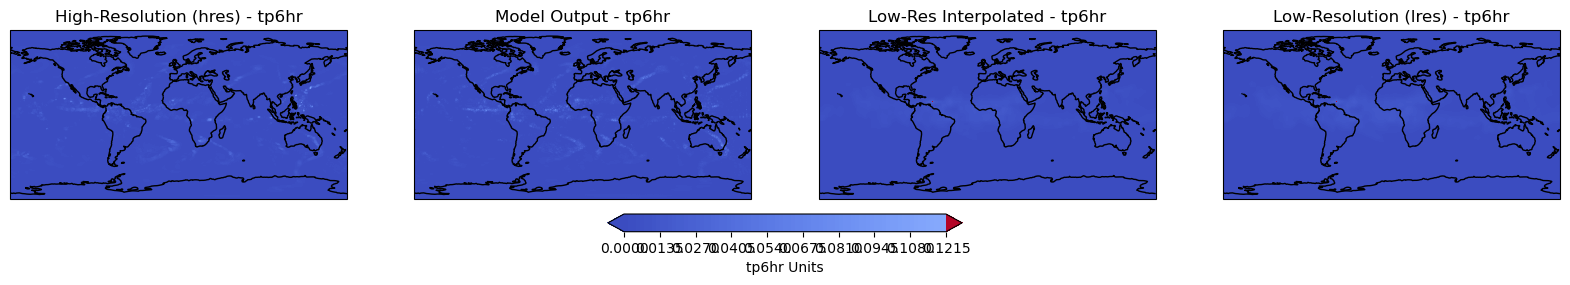

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Define coordinates
loncoords_hres = np.linspace(-180, 180, hres_stacked.shape[3])     g# For high-res and lres_interp data (1440 points)
latcoords_hres = np.linspace(-90, 90, hres_stacked.shape[2])       # For high-res and lres_interp data (721 points)
loncoords_lres = np.linspace(-180, 180, lres_stacked.shape[3])     # For low-res data
latcoords_lres = np.linspace(-90, 90, lres_stacked.shape[2])       # For low-res data

# Set up the plotting parameters
projection = ccrs.PlateCarree()

# Define vmin and vmax based on combined data
vmin_tp6hr = min(
    hres_tp6hr_denorm.min(),
    output_tp6hr_denorm.min(),
    lres_tp6hr_denorm.min(),
    lres_interp_tp6hr_denorm.min()
)
vmax_tp6hr = max(
    hres_tp6hr_denorm.max(),
    output_tp6hr_denorm.max(),
    lres_tp6hr_denorm.max(),
    lres_interp_tp6hr_denorm.max()
)

# Plotting 'tp6hr' channel (first sample)
sample_idx = 0

fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': projection})
data_to_plot = [
    (hres_tp6hr_denorm[sample_idx, :, :], "High-Resolution (hres)", loncoords_hres, latcoords_hres),
    (output_tp6hr_denorm[sample_idx, :, :], "Model Output", loncoords_hres, latcoords_hres),
    (lres_interp_tp6hr_denorm[sample_idx, :, :], "Low-Res Interpolated", loncoords_hres, latcoords_hres),
    (lres_tp6hr_denorm[sample_idx, :, :], "Low-Resolution (lres)", loncoords_lres, latcoords_lres)
]

# Collect all images to adjust colorbar later
ims = []

for ax, (data, title, loncoords, latcoords) in zip(axs, data_to_plot):
    im = ax.contourf(
        loncoords, latcoords, data, levels=100, vmin=vmin_tp6hr, vmax=vmax_tp6hr,
        transform=projection, cmap="coolwarm", extend="both"
    )
    ax.coastlines()
    ax.set_title(f"{title} - tp6hr")
    ims.append(im)

# Add a colorbar common to all subplots
cbar = fig.colorbar(ims[0], ax=axs, orientation="horizontal", fraction=0.046, pad=0.04)
cbar.set_label("tp6hr Units")  # Replace with appropriate units

# plt.tight_layout()
plt.show()

## Calculate Mean Metrics Across Samples ± Std

In [19]:
import numpy as np
import torch

def latitude_weighted_rmse(pred, target):
    """
    Calculate the latitude-weighted RMSE between predicted and target tensors.
    Args:
        pred (torch.Tensor): Predicted tensor of shape (latitudes, longitudes).
        target (torch.Tensor): Target tensor of shape (latitudes, longitudes).
    Returns:
        float: Latitude-weighted RMSE value.
    """
    latitudes = torch.linspace(-90, 90, steps=pred.size(0), device=pred.device)
    weights = torch.cos(latitudes * np.pi / 180).unsqueeze(1).expand_as(pred)
    weighted_squared_diff = weights * (pred - target) ** 2
    rmse = torch.sqrt(weighted_squared_diff.sum() / weights.sum())
    return rmse.item()

def ssim(pred, target, window_size=11, size_average=True):
    """
    Calculate the SSIM between predicted and target tensors.
    Args:
        pred (torch.Tensor): Predicted tensor of shape (latitudes, longitudes).
        target (torch.Tensor): Target tensor of shape (latitudes, longitudes).
        window_size (int): Size of the Gaussian window. Default is 11.
        size_average (bool): Whether to average the SSIM over the entire image.
    Returns:
        float: SSIM value.
    """
    import torch.nn.functional as F

    # Add batch and channel dimensions
    pred = pred.unsqueeze(0).unsqueeze(0)
    target = target.unsqueeze(0).unsqueeze(0)
    channel = pred.size(1)

    def create_window(window_size, channel):
        _1D_window = torch.hann_window(window_size, periodic=False, device=pred.device)
        _2D_window = _1D_window.unsqueeze(1) * _1D_window.unsqueeze(0)
        window = _2D_window / _2D_window.sum()
        window = window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    window = create_window(window_size, channel)
    mu1 = F.conv2d(pred, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(target, window, padding=window_size//2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(pred * pred, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(target * target, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(pred * target, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = (0.01 * max(pred.max(), target.max())) ** 2
    C2 = (0.03 * max(pred.max(), target.max())) ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean().item()
    else:
        return ssim_map.squeeze().cpu().numpy()

# Initialize lists to hold metric values
rmse_values = []
ssim_values = []

num_samples = hres_tp6hr_denorm.shape[0]

for i in range(num_samples):
    # Extract data for the current sample
    pred_sample = output_tp6hr_denorm[i, :, :]
    target_sample = hres_tp6hr_denorm[i, :, :]

    # Convert to torch tensors
    pred_tensor = torch.tensor(pred_sample, dtype=torch.float32)
    target_tensor = torch.tensor(target_sample, dtype=torch.float32)

    # Compute metrics
    rmse = latitude_weighted_rmse(pred_tensor, target_tensor)
    ssim_value = ssim(pred_tensor, target_tensor)

    # Append to lists
    rmse_values.append(rmse)
    ssim_values.append(ssim_value)

# Calculate mean and std of the metrics
rmse_mean = np.mean(rmse_values)
rmse_std = np.std(rmse_values)

ssim_mean = np.mean(ssim_values)
ssim_std = np.std(ssim_values)

print(f"Latitude-Weighted RMSE: {rmse_mean:.4f} ± {rmse_std:.4f}")
print(f"SSIM: {ssim_mean:.4f} ± {ssim_std:.4f}")

Latitude-Weighted RMSE: 0.0024 ± 0.0002
SSIM: 0.9498 ± 0.0164


## Calculate Power Spectrum and Std

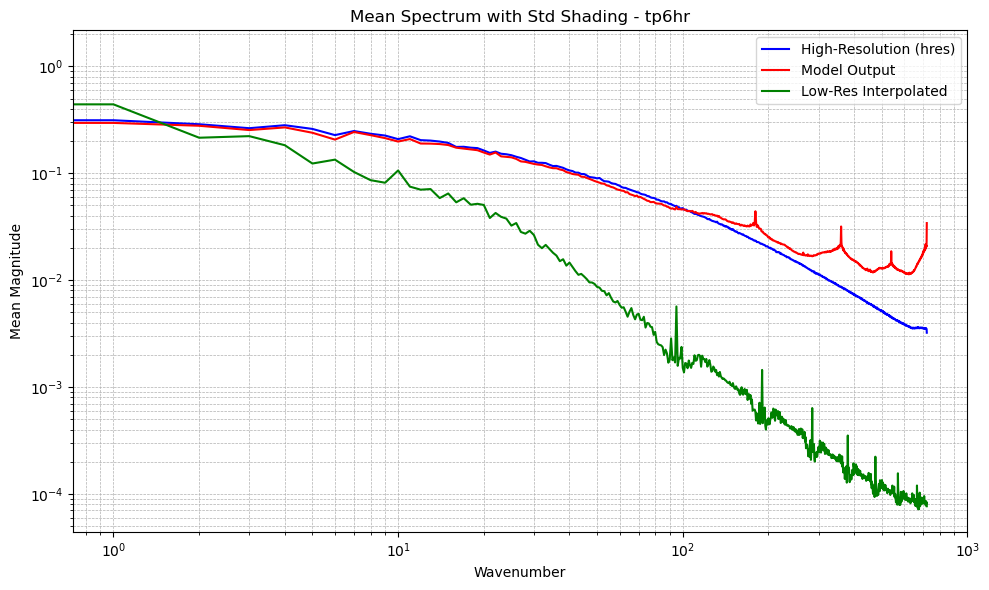

In [31]:
def compute_spectrum_torch(data):
    """
    Compute the magnitude spectrum of the data using rFFT along the longitude axis.
    Args:
        data (numpy.ndarray or torch.Tensor): Data array of shape (samples, latitudes, longitudes).
    Returns:
        numpy.ndarray: Magnitude spectrum of shape (samples, latitudes, frequencies)
    """
    # Ensure data is a torch tensor
    if not isinstance(data, torch.Tensor):
        data_torch = torch.tensor(data, dtype=torch.float32)
    else:
        data_torch = data.float()

    # Perform rFFT along the longitude axis (-1)
    spectrum = torch.fft.rfft(data_torch, dim=-1)

    # Compute magnitude of the spectrum
    magnitude_spectrum = torch.abs(spectrum)

    return magnitude_spectrum.numpy()  # Shape: (samples, latitudes, frequencies)

# Compute the spectra
hres_spectrum = compute_spectrum_torch(hres_tp6hr_denorm)
output_spectrum = compute_spectrum_torch(output_tp6hr_denorm)
lres_interp_spectrum = compute_spectrum_torch(lres_interp_tp6hr_denorm)

# Flatten samples and latitudes
hres_spectrum_flat = hres_spectrum.reshape(-1, hres_spectrum.shape[2])
output_spectrum_flat = output_spectrum.reshape(-1, output_spectrum.shape[2])
lres_interp_spectrum_flat = lres_interp_spectrum.reshape(-1, lres_interp_spectrum.shape[2])

# Compute mean and std across the flattened dimension
hres_spectrum_mean = hres_spectrum_flat.mean(axis=0)
hres_spectrum_std = hres_spectrum_flat.std(axis=0)

output_spectrum_mean = output_spectrum_flat.mean(axis=0)
output_spectrum_std = output_spectrum_flat.std(axis=0)

lres_interp_spectrum_mean = lres_interp_spectrum_flat.mean(axis=0)
lres_interp_spectrum_std = lres_interp_spectrum_flat.std(axis=0)

# Wavenumbers
longitude_points = hres_tp6hr_denorm.shape[2]
wavenumbers = np.arange(0, longitude_points // 2 + 1)

# Plotting the spectra
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting High-Resolution Spectrum
plt.loglog(wavenumbers, hres_spectrum_mean, label="High-Resolution (hres)", color="blue")
# plt.fill_between(wavenumbers, hres_spectrum_mean - hres_spectrum_std, hres_spectrum_mean + hres_spectrum_std, color="blue", alpha=0.3)

# Plotting Model Output Spectrum
plt.loglog(wavenumbers, output_spectrum_mean, label="Model Output", color="red")
# plt.fill_between(wavenumbers, output_spectrum_mean - output_spectrum_std, output_spectrum_mean + output_spectrum_std, color="red", alpha=0.3)

# Plotting Low-Res Interpolated Spectrum
plt.loglog(wavenumbers, lres_interp_spectrum_mean, label="Low-Res Interpolated", color="green")
# plt.fill_between(wavenumbers, lres_interp_spectrum_mean - lres_interp_spectrum_std, lres_interp_spectrum_mean + lres_interp_spectrum_std, color="green", alpha=0.3)

plt.title("Mean Spectrum with Std Shading - tp6hr")
plt.xlabel("Wavenumber")
plt.ylabel("Mean Magnitude")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

In [18]:
# Cell 1: Load Data, Denormalize, and Transform 'Temperature_7' Channel

import numpy as np
import os
import torch

# Define the path and load the data
task_name = "vae_concat_lsm"
path = f"/glade/derecho/scratch/mdarman/lucie/results/{task_name}/samples"

# Initialize lists to hold all loaded samples
all_hres_samples = []
all_output_samples = []
all_lres_samples = []
all_lres_interp_samples = []

# Loop over the files and load the data
for idx in range(1, 32):
    with np.load(os.path.join(path, f'{idx}.npz')) as data:
        lres = data['lres']              # Shape: [batch_size, channels, 48, 96]
        lres_interp = data['lres_interp']  # Shape: [batch_size, channels, 721, 1440]
        hres = data['hres']              # Shape: [batch_size, channels, 721, 1440]
        output = data['output']          # Shape: [batch_size, channels, 720, 1440]

        # Adjust output shape if necessary
        if output.shape[2] != hres.shape[2]:
            # Pad the output to match hres in latitude dimension
            pad_width = hres.shape[2] - output.shape[2]
            output = np.pad(output, ((0, 0), (0, 0), (0, pad_width), (0, 0)), mode='edge')

        # Append to lists
        all_hres_samples.append(hres)
        all_output_samples.append(output)
        all_lres_samples.append(lres)
        all_lres_interp_samples.append(lres_interp)

# Stack all samples
hres_stacked = np.concatenate(all_hres_samples, axis=0)
output_stacked = np.concatenate(all_output_samples, axis=0)
lres_stacked = np.concatenate(all_lres_samples, axis=0)
lres_interp_stacked = np.concatenate(all_lres_interp_samples, axis=0)

print("Stacked hres shape:", hres_stacked.shape)
print("Stacked output shape:", output_stacked.shape)
print("Stacked lres shape:", lres_stacked.shape)
print("Stacked lres_interp shape:", lres_interp_stacked.shape)

# Load denormalization statistics
lr_stats = np.load("/glade/derecho/scratch/mdarman/lucie/stats_2000_2003_lr.npz", allow_pickle=True)
hr_stats = np.load("/glade/derecho/scratch/mdarman/lucie/stats_2000_2003_hr.npz", allow_pickle=True)

# Extract mean and std for 'Temperature_7'
temperature_mean_hr = hr_stats['2m_temperature'].item()['mean']
temperature_std_hr = hr_stats['2m_temperature'].item()['std']

temperature_mean_lr = lr_stats['Temperature_7'].item()['mean']
temperature_std_lr = lr_stats['Temperature_7'].item()['std']

# Denormalize 'Temperature_7' channel (index 0)
# For hres, output, lres, and lres_interp
hres_temperature_denorm = hres_stacked[:, 0, :, :] * temperature_std_hr + temperature_mean_hr
output_temperature_denorm = output_stacked[:, 0, :, :] * temperature_std_hr + temperature_mean_hr
lres_temperature_denorm = lres_stacked[:, 0, :, :] * temperature_std_lr + temperature_mean_lr
lres_interp_temperature_denorm = lres_interp_stacked[:, 0, :, :] * temperature_std_hr + temperature_mean_hr

Stacked hres shape: (62, 2, 721, 1440)
Stacked output shape: (62, 2, 721, 1440)
Stacked lres shape: (62, 6, 48, 96)
Stacked lres_interp shape: (62, 6, 721, 1440)


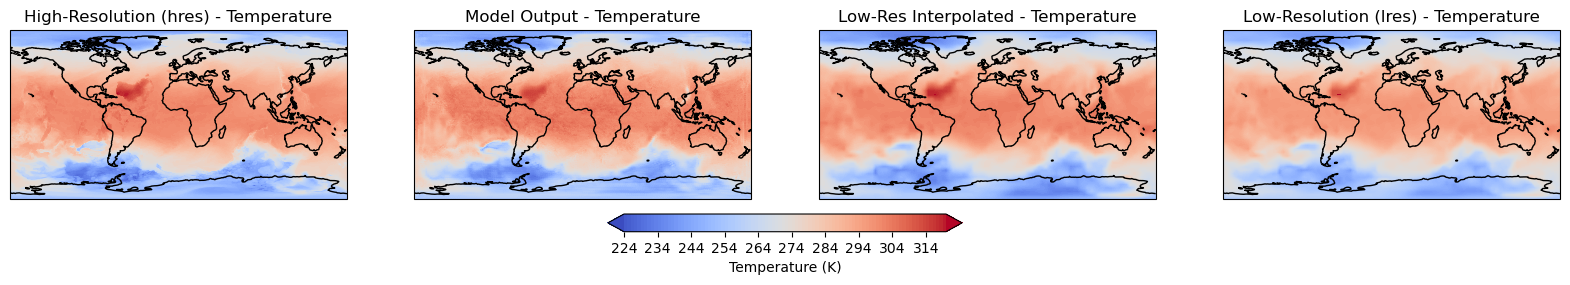

In [10]:
# Cell 2: Visualization

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Define coordinates
loncoords_hres = np.linspace(-180, 180, hres_stacked.shape[3])     # For high-res and lres_interp data (1440 points)
latcoords_hres = np.linspace(-90, 90, hres_stacked.shape[2])       # For high-res and lres_interp data (721 points)
loncoords_lres = np.linspace(-180, 180, lres_stacked.shape[3])     # For low-res data
latcoords_lres = np.linspace(-90, 90, lres_stacked.shape[2])       # For low-res data

# Set up the plotting parameters
projection = ccrs.PlateCarree()

# Define vmin and vmax based on combined data
vmin_temperature = min(
    hres_temperature_denorm.min(),
    output_temperature_denorm.min(),
    lres_temperature_denorm.min(),
    lres_interp_temperature_denorm.min()
)
vmax_temperature = max(
    hres_temperature_denorm.max(),
    output_temperature_denorm.max(),
    lres_temperature_denorm.max(),
    lres_interp_temperature_denorm.max()
)

# Plotting 'Temperature_7' channel (first sample)
sample_idx = 0

fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': projection})
data_to_plot = [
    (hres_temperature_denorm[sample_idx, :, :], "High-Resolution (hres)", loncoords_hres, latcoords_hres),
    (output_temperature_denorm[sample_idx, :, :], "Model Output", loncoords_hres, latcoords_hres),
    (lres_interp_temperature_denorm[sample_idx, :, :], "Low-Res Interpolated", loncoords_hres, latcoords_hres),
    (lres_temperature_denorm[sample_idx, :, :], "Low-Resolution (lres)", loncoords_lres, latcoords_lres)
]

# Collect all images to adjust colorbar later
ims = []

for ax, (data, title, loncoords, latcoords) in zip(axs, data_to_plot):
    im = ax.contourf(
        loncoords, latcoords, data, levels=100, vmin=vmin_temperature, vmax=vmax_temperature,
        transform=projection, cmap="coolwarm", extend="both"
    )
    ax.coastlines()
    ax.set_title(f"{title} - Temperature")
    ims.append(im)

# Add a colorbar common to all subplots
cbar = fig.colorbar(ims[0], ax=axs, orientation="horizontal", fraction=0.046, pad=0.04)
cbar.set_label("Temperature (K)")

# plt.tight_layout()
plt.show()

In [14]:
# Cell 3: Calculate Mean Metrics Across Samples ± Std

import numpy as np
import torch

def latitude_weighted_rmse(pred, target):
    """
    Calculate the latitude-weighted RMSE between predicted and target tensors.
    Args:
        pred (torch.Tensor): Predicted tensor of shape (latitudes, longitudes).
        target (torch.Tensor): Target tensor of shape (latitudes, longitudes).
    Returns:
        float: Latitude-weighted RMSE value.
    """
    latitudes = torch.linspace(-90, 90, steps=pred.size(0), device=pred.device)
    weights = torch.cos(latitudes * np.pi / 180).unsqueeze(1).expand_as(pred)
    weighted_squared_diff = weights * (pred - target) ** 2
    rmse = torch.sqrt(weighted_squared_diff.sum() / weights.sum())
    return rmse.item()

def ssim(pred, target, window_size=11, size_average=True):
    """
    Calculate the SSIM between predicted and target tensors.
    Args:
        pred (torch.Tensor): Predicted tensor of shape (latitudes, longitudes).
        target (torch.Tensor): Target tensor of shape (latitudes, longitudes).
        window_size (int): Size of the Gaussian window. Default is 11.
        size_average (bool): Whether to average the SSIM over the entire image.
    Returns:
        float: SSIM value.
    """
    import torch.nn.functional as F

    # Add batch and channel dimensions
    pred = pred.unsqueeze(0).unsqueeze(0)
    target = target.unsqueeze(0).unsqueeze(0)
    channel = pred.size(1)

    def create_window(window_size, channel):
        _1D_window = torch.hann_window(window_size, periodic=False, device=pred.device)
        _2D_window = _1D_window.unsqueeze(1) * _1D_window.unsqueeze(0)
        window = _2D_window / _2D_window.sum()
        window = window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    window = create_window(window_size, channel)
    mu1 = F.conv2d(pred, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(target, window, padding=window_size//2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(pred * pred, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(target * target, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(pred * target, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = (0.01 * max(pred.max(), target.max())) ** 2
    C2 = (0.03 * max(pred.max(), target.max())) ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean().item()
    else:
        return ssim_map.squeeze().cpu().numpy()

# Initialize lists to hold metric values
rmse_values = []
ssim_values = []

num_samples = hres_temperature_denorm.shape[0]

for i in range(num_samples):
    # Extract data for the current sample
    pred_sample = output_temperature_denorm[i, :, :]
    target_sample = hres_temperature_denorm[i, :, :]

    # Convert to torch tensors
    pred_tensor = torch.tensor(pred_sample, dtype=torch.float32)
    target_tensor = torch.tensor(target_sample, dtype=torch.float32)

    # Compute metrics
    rmse = latitude_weighted_rmse(pred_tensor, target_tensor)
    ssim_value = ssim(pred_tensor, target_tensor)

    # Append to lists
    rmse_values.append(rmse)
    ssim_values.append(ssim_value)

# Calculate mean and std of the metrics
rmse_mean = np.mean(rmse_values)
rmse_std = np.std(rmse_values)

ssim_mean = np.mean(ssim_values)
ssim_std = np.std(ssim_values)

print(f"Latitude-Weighted RMSE: {rmse_mean:.4f} ± {rmse_std:.4f}")
print(f"SSIM: {ssim_mean:.4f} ± {ssim_std:.4f}")

Latitude-Weighted RMSE: 3.0245 ± 0.1138
SSIM: 0.9767 ± 0.0006


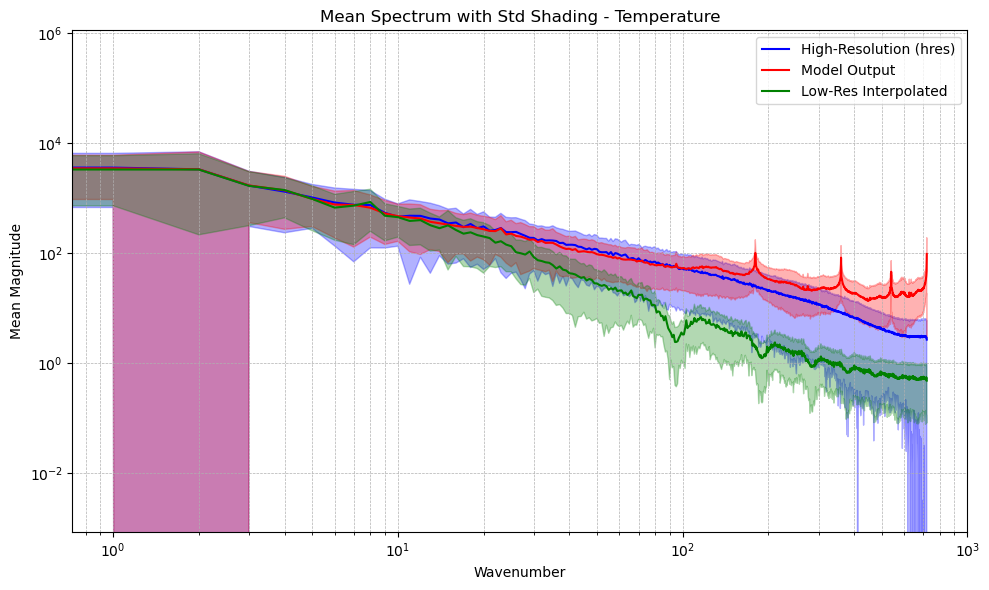

In [12]:
# Cell 4: Calculate Power Spectrum and Std

def compute_spectrum_torch(data):
    """
    Compute the magnitude spectrum of the data using rFFT along the longitude axis.
    Args:
        data (numpy.ndarray or torch.Tensor): Data array of shape (samples, latitudes, longitudes).
    Returns:
        numpy.ndarray: Magnitude spectrum of shape (samples, latitudes, frequencies)
    """
    # Ensure data is a torch tensor
    if not isinstance(data, torch.Tensor):
        data_torch = torch.tensor(data, dtype=torch.float32)
    else:
        data_torch = data.float()

    # Perform rFFT along the longitude axis (-1)
    spectrum = torch.fft.rfft(data_torch, dim=-1)

    # Compute magnitude of the spectrum
    magnitude_spectrum = torch.abs(spectrum)

    return magnitude_spectrum.numpy()  # Shape: (samples, latitudes, frequencies)

# Compute the spectra
hres_spectrum = compute_spectrum_torch(hres_temperature_denorm)
output_spectrum = compute_spectrum_torch(output_temperature_denorm)
lres_interp_spectrum = compute_spectrum_torch(lres_interp_temperature_denorm)

# Flatten samples and latitudes
hres_spectrum_flat = hres_spectrum.reshape(-1, hres_spectrum.shape[2])
output_spectrum_flat = output_spectrum.reshape(-1, output_spectrum.shape[2])
lres_interp_spectrum_flat = lres_interp_spectrum.reshape(-1, lres_interp_spectrum.shape[2])

# Compute mean and std across the flattened dimension
hres_spectrum_mean = hres_spectrum_flat.mean(axis=0)
hres_spectrum_std = hres_spectrum_flat.std(axis=0)

output_spectrum_mean = output_spectrum_flat.mean(axis=0)
output_spectrum_std = output_spectrum_flat.std(axis=0)

lres_interp_spectrum_mean = lres_interp_spectrum_flat.mean(axis=0)
lres_interp_spectrum_std = lres_interp_spectrum_flat.std(axis=0)

# Wavenumbers
longitude_points = hres_temperature_denorm.shape[2]
wavenumbers = np.arange(0, longitude_points // 2 + 1)

# Plotting the spectra
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting High-Resolution Spectrum
plt.loglog(wavenumbers, hres_spectrum_mean, label="High-Resolution (hres)", color="blue")
plt.fill_between(wavenumbers, hres_spectrum_mean - hres_spectrum_std, hres_spectrum_mean + hres_spectrum_std, color="blue", alpha=0.3)

# Plotting Model Output Spectrum
plt.loglog(wavenumbers, output_spectrum_mean, label="Model Output", color="red")
plt.fill_between(wavenumbers, output_spectrum_mean - output_spectrum_std, output_spectrum_mean + output_spectrum_std, color="red", alpha=0.3)

# Plotting Low-Res Interpolated Spectrum
plt.loglog(wavenumbers, lres_interp_spectrum_mean, label="Low-Res Interpolated", color="green")
plt.fill_between(wavenumbers, lres_interp_spectrum_mean - lres_interp_spectrum_std, lres_interp_spectrum_mean + lres_interp_spectrum_std, color="green", alpha=0.3)

plt.title("Mean Spectrum with Std Shading - Temperature")
plt.xlabel("Wavenumber")
plt.ylabel("Mean Magnitude")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

# Plotting Mean Spectra Across All Samples:

Stacked hres shape: (62, 2, 721, 1440)
Stacked decoded_outputs shape: (62, 2, 721, 1440)
Stacked lres_interp shape: (62, 6, 721, 1440)
torch.Size([62, 721, 721])
torch.Size([62, 721, 721])
torch.Size([62, 721, 721])
torch.Size([62, 721, 721])
torch.Size([62, 721, 721])
torch.Size([62, 721, 721])


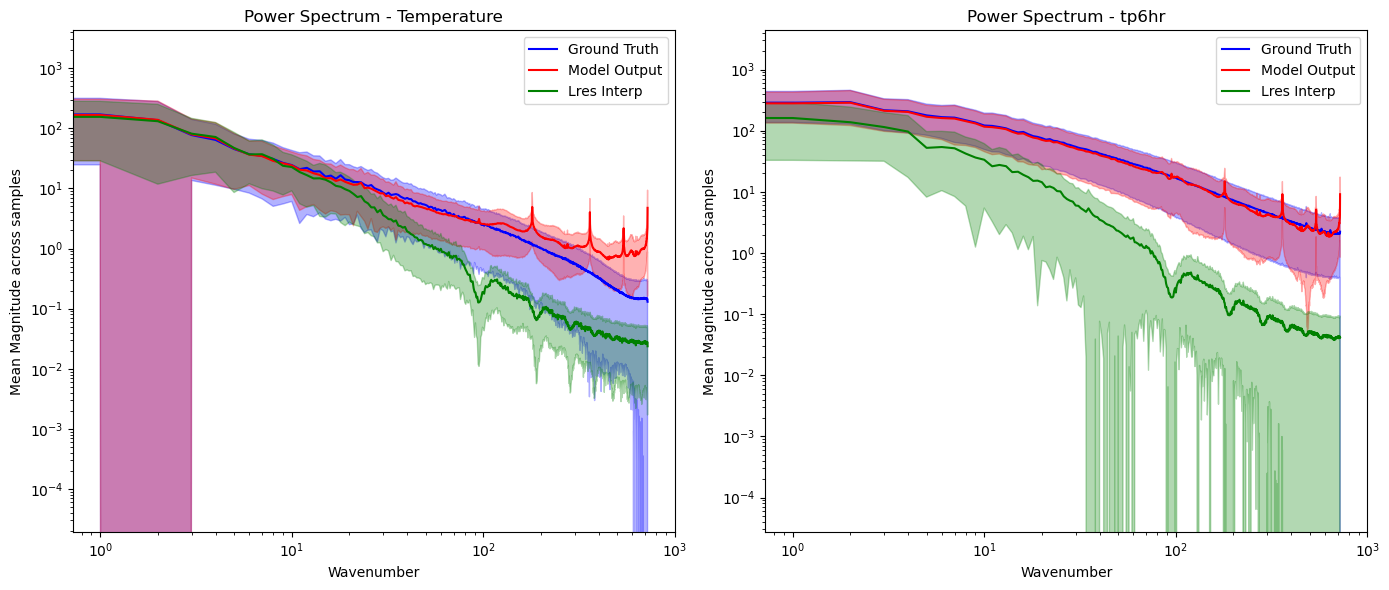

In [10]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

# Directory containing the sample files
path = "/glade/derecho/scratch/mdarman/lucie/results/vae_concat_lsm/samples"

# Initialize lists to hold all loaded samples for both ground truth and model output
all_hres_samples = []
all_decoded_samples = []
all_lres_interp = []

# Loop over the files and load the data
for idx in range(1, 32):
    with np.load(os.path.join(path, f'{idx}.npz')) as data:
        hres_loaded = data['hres']             # Shape: [batch_size, channels, 721, 1440]
        decoded_output_loaded = data['output']  # Shape: [batch_size, channels, 720, 1440]
        lres_loaded_interp = data['lres_interp']

        # Adjust shapes if necessary to match dimensions
        if decoded_output_loaded.shape[2] != hres_loaded.shape[2]:
            # Pad decoded_output_loaded to match hres_loaded in the latitude dimension
            pad_width = hres_loaded.shape[2] - decoded_output_loaded.shape[2]
            decoded_output_loaded = np.pad(decoded_output_loaded, ((0, 0), (0, 0), (0, pad_width), (0, 0)), mode='edge')

        # Append each loaded batch to the respective lists
        all_hres_samples.append(hres_loaded)
        all_decoded_samples.append(decoded_output_loaded)
        all_lres_interp.append(lres_loaded_interp)

# Stack all samples along the first dimension
all_hres_stacked = np.concatenate(all_hres_samples, axis=0)          # Shape: (total_samples, channels, 721, 1440)
all_decoded_stacked = np.concatenate(all_decoded_samples, axis=0)    # Shape: (total_samples, channels, 721, 1440)
all_lres_interp_stacked = np.concatenate(all_lres_interp, axis=0)    # Shape: (total_samples, channels, 721, 1440)

print("Stacked hres shape:", all_hres_stacked.shape)
print("Stacked decoded_outputs shape:", all_decoded_stacked.shape)
print("Stacked lres_interp shape:", all_lres_interp_stacked.shape)

# Get the number of longitude points
longitude_points = all_hres_stacked.shape[3]  # Assumes hres has shape (samples, channels, latitudes, longitudes)

# Define wavenumbers from 0 to longitude_points // 2
wavenumbers = np.arange(0, longitude_points // 2 + 1)

# Compute the mean and std spectrum for each channel across all samples
channels = ["Temperature", "tp6hr"]
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for i, channel in enumerate(channels):
    hres_channel_data = all_hres_stacked[:, i, :, :]
    decoded_channel_data = all_decoded_stacked[:, i, :, :]
    lres_interp_channel_data = all_lres_interp_stacked[:, i, :, :]
    
    # Compute mean and std spectra
    mean_spectra_hres, std_spectra_hres = compute_mean_std_spectrum_torch(hres_channel_data)
    mean_spectra_decoded, std_spectra_decoded = compute_mean_std_spectrum_torch(decoded_channel_data)
    mean_spectra_lres_interp, std_spectra_lres_interp = compute_mean_std_spectrum_torch(lres_interp_channel_data)
    
    # Plotting Ground Truth
    axs[i].loglog(wavenumbers, mean_spectra_hres, label="Ground Truth", color="blue")
    axs[i].fill_between(wavenumbers, mean_spectra_hres - std_spectra_hres, mean_spectra_hres + std_spectra_hres, color="blue", alpha=0.3)
    
    # Plotting Model Output
    axs[i].loglog(wavenumbers, mean_spectra_decoded, label="Model Output", color="red")
    axs[i].fill_between(wavenumbers, mean_spectra_decoded - std_spectra_decoded, mean_spectra_decoded + std_spectra_decoded, color="red", alpha=0.3)
    
    # Plotting Lres Interp
    axs[i].loglog(wavenumbers, mean_spectra_lres_interp, label="Lres Interp", color="green")
    axs[i].fill_between(wavenumbers, mean_spectra_lres_interp - std_spectra_lres_interp, mean_spectra_lres_interp + std_spectra_lres_interp, color="green", alpha=0.3)
    
    axs[i].set_title(f"Power Spectrum - {channel}")
    axs[i].set_xlabel("Wavenumber")
    axs[i].set_ylabel("Mean Magnitude across samples")
    axs[i].legend()
    # axs[i].grid(True, which="both", ls="--", lw=0.5)

plt.tight_layout()
plt.show()

In [1]:
import numpy as np

lucie_path = "/glade/u/home/mdarman/LUCIE_inference_start2010.npz"
lucie_data = np.load(lucie_path)

# Print the channels
print("Channels in LUCIE data:")
for key in lucie_data.keys():
    print(lucie_data['data'].shape)
    print


# Extract the 'Temperature' and 'tp6hr' channels



Channels in LUCIE data:
(14600, 48, 96, 6)
